# **Question 3**

## Overall workflow
1.  Audio Input
2.  Neural Network Classifies audio inputs (mediapipe yamnet)
3.  Process the output of Neural Network and Prepare a prompt.
4.  Generate an image using Text to Image AI model (Playground)
5.  Output Image
 


# How it works and what it does:
 
1. donwload, install and import all the necessary libraries by running the first code cell
2. We support 2 audio formats:
	1. wav (directly)
	2. mp3 (we provide utility function to convert mp3 to wav)
3. Provide your audio path to audio classifier function
4. the classifier functions passes the audio file to the model (yamnet by mediapipe) 
5. The model will output a a list of categories against each timestamp of the audio
		
		e.g: 

		Timestamp 0: Dog (0.26)

		Timestamp 1: Domestic animals, pets (0.20)

		Timestamp 2: Domestic animals, pets (0.26)
 
6. Process the output of the model and prepare a prompt using get_top_categories() function
 
7. send the prompt to the model and get the output image
 

# Import Statements

In [3]:
!pip install -q mediapipe
!pip install pydub ffmpeg
!wget -O classifier.tflite -q https://storage.googleapis.com/mediapipe-models/audio_classifier/yamnet/float32/1/yamnet.tflite

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=0c581f7288e8186384d44505c98a44737ee2ec1c5bee9b11c6175622ba427d3c
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


## Function for converting MP3 to Wav

In [ ]:

# Import libraries
from pydub import AudioSegment

def convert_mp3_to_wav(input_mp3_path, output_wav_path):
    """
    Converts an MP3 file to WAV format in Google Colab.

    Parameters:
        input_mp3_path (str): Path to the input MP3 file.
        output_wav_path (str): Path to save the converted WAV file.

    Returns:
        None
    """
    try:
        # Load the MP3 file
        print(f"Converting MP3 to WAV: {input_mp3_path}")
        audio = AudioSegment.from_mp3(input_mp3_path)
        # Export the audio as a WAV file
        audio.export(output_wav_path, format="wav")
        print(f"Conversion successful: {output_wav_path}")
    except Exception as e:
        print(f"An error occurred during conversion: {e}")


## Helper Funcitons for getting all the auido files in the working directory

In [ ]:
import os

def get_all_mp3_files(directory):
    """
    Get all file paths with .mp3 extension from a directory.

    Parameters:
        directory (str): Path to the directory to search.

    Returns:
        list: List of file paths with .mp3 extension.
    """
    mp3_files = []
    try:
        # Walk through the directory
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(".mp3"):
                    mp3_files.append(os.path.join(root, file))
        return mp3_files
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Example usage
mp3_files = get_all_mp3_files("mp3/")
print("Found MP3 files:", mp3_files)

Found MP3 files: []


In [ ]:
output_wav_path = "output/"  # Name for the converted WAV file
# input_mp3_paths = mp3_files

for i, path in enumerate(mp3_files):
  print(path)
  output = output_wav_path + str(i) + ".wav"
  convert_mp3_to_wav(path,output)


## Audio classification

In [ ]:
import numpy as np

from mediapipe.tasks import python
from mediapipe.tasks.python.components import containers
from mediapipe.tasks.python import audio
from scipy.io import wavfile


In [ ]:
audio_file_name = "/content/output6.wav"

In [ ]:
def audio_classifier(audio_imput):

  # Customize and associate model for Classifier
  base_options = python.BaseOptions(model_asset_path='classifier.tflite')
  options = audio.AudioClassifierOptions(
      base_options=base_options, max_results=4)

  # Create classifier, segment audio clips, and classify
  with audio.AudioClassifier.create_from_options(options) as classifier:
    sample_rate, wav_data = wavfile.read(audio_imput)
    audio_clip = containers.AudioData.create_from_array(
        wav_data.astype(float) / np.iinfo(np.int16).max, sample_rate)
    classification_result_list = classifier.classify(audio_clip)

    
    results = ""
  # Iterate through clips to display classifications
    for idx, timestamp in enumerate(range(len(classification_result_list))):
      classification_result = classification_result_list[idx]
      top_category = classification_result.classifications[0].categories[0]
      output = f'Timestamp {timestamp}: {top_category.category_name} ({top_category.score:.2f})'
      results += output + "\n"
  
  return results



## Function to aid in generating prompt

In [ ]:
from collections import Counter

def get_top_categories(input_string):
    """
    Processes the input string of timestamps, extracts categories,
    and returns the top 2 most frequent categories as a comma-separated string.

    Args:
        input_string (str): Multiline string containing timestamp data.

    Returns:
        str: A comma-separated string of the top 2 categories.
    """
    # Split the input into lines
    lines = input_string.strip().split("\n")

    # Extract categories
    categories = []
    for line in lines:
        try:
            # Extract the category part using string slicing
            category_start = line.find(":") + 2
            category_end = line.rfind("(") - 1
            category = line[category_start:category_end].strip()
            categories.append(category)
        except Exception as e:
            print(f"Error processing line: {line}. Error: {e}")

    # Count occurrences of each category
    category_counts = Counter(categories)

    # Get the top 2 most frequent categories
    top_categories = [category for category, count in category_counts.most_common(2)]

    # Return categories as a comma-separated string
    return ", ".join(top_categories)


# complete pipeline

In [ ]:
audio_file_name = "/content/output6.wav" # input your sound file here
audio_classifier_output = audio_classifier(audio_file_name)

  0%|          | 0/50 [00:00<?, ?it/s]

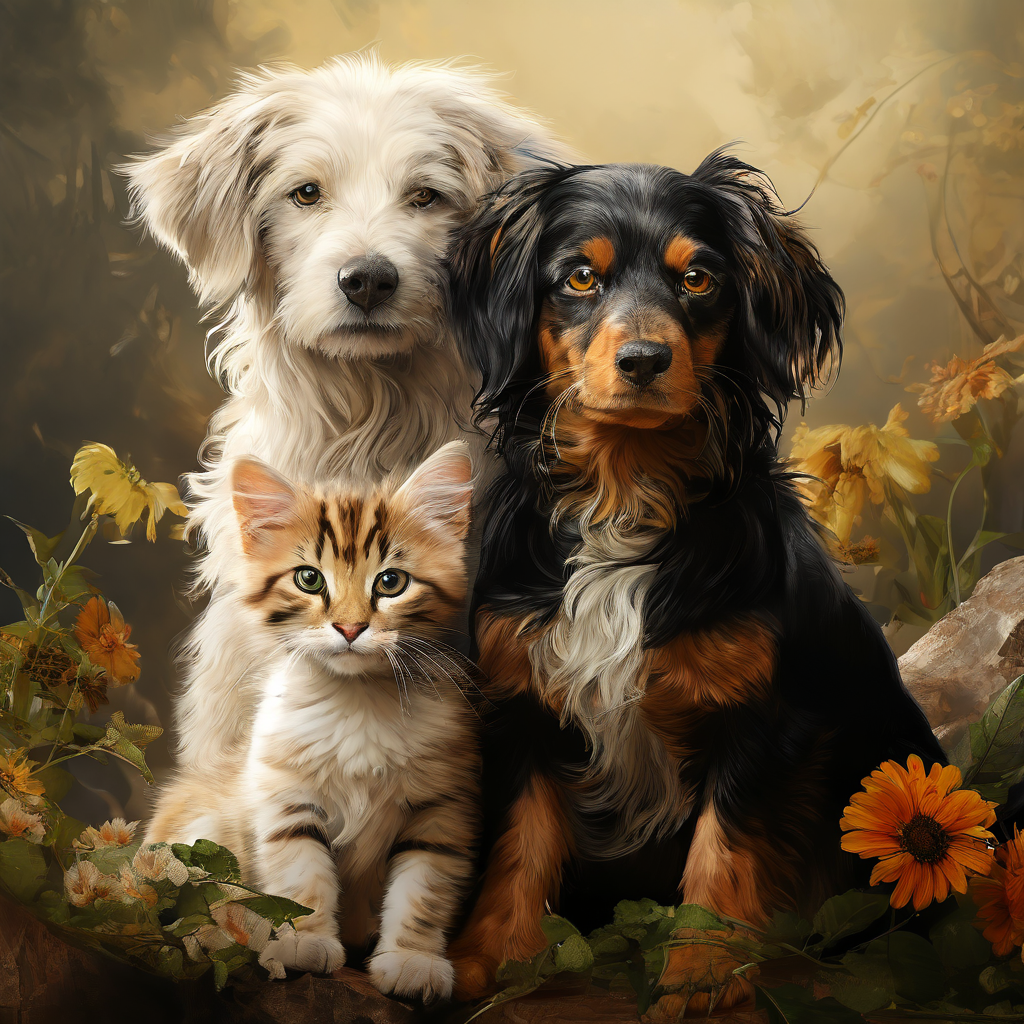

In [ ]:
prompt = f"generate an image of {get_top_categories(audio_classifier_output)}"
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]

image